# Feature extraction and reverse image search

This notebook will guide you through the procedure of analyzing a large set of images using a pre-trained convolutional network, extracting feature vectors for each one which represent each image. 

After the analysis is done, we will review some retrieval tasks that you can do with such an analysis. The main task will be that of "reverse image search," which refers to searching for the most similar set of images to some query image. 

### Prepare a dataset

You will need a folder of images to analyze. There is no limit to the size of the dataset, but for good results, at least 1000 would be good.

We'll start by importing the relevant Keras libraries that we'll be using.

In [1]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from tensorflow import keras

We will load a previously-trained neural network, that of VGG16, which comes with Keras. If it's your first time loading it, it will automatically download the weights for you, which will take some time. Afterwards, the weights will be cached locally for future use. Keras has a number of other [pre-trained networs](https://keras.io/applications/) which you can try as well.

In [2]:
# Load VGG16.
import tensorflow as tf
config = tf.compat.v1.ConfigProto

model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)

Look at the model summary to see how it's structured.

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

The summary gives us a layer-by-layer description of the network. Notice that VGG16 is a deep network with 13 convolutional layers. It was previously trained on millions of images, and has over 100,000,000 weights and biases, the majority of which connect to the first fully-connected layer (fc1). VGG-16 is setup to take a fixed-size (224 x 224 x 3) RGB image at its input, and then forward it through a series of altrnating convolutional and max-pooling layers, then capped off by three fully-connected layers of 4096, 4096, and 1000 neurons, where the last layer is our softmax classification layer.

Notice that the output shape at each layer has `None` the first dimension. This is because the network can process multiple images in a single batch. So if you forward 5 images at shape [5, 224, 224, 3], then the output shape at each layer will be 5 in the first dimension.

### Forwarding an image through the network

In order to input an image into the network, it has to be pre-processed into a feature vector of the correct size. To help us do this, we will create a function `load_image(path)` which will handle the usual pre-processing steps: load an image from our file system and turn it into an input vector of the correct dimensions, those expected by VGG16, namely a color image of size 224x224.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

We'll load the image of the dog in the `data` directory, and take a look at its data vector.

shape of x:  (1, 224, 224, 3)
data type:  float32


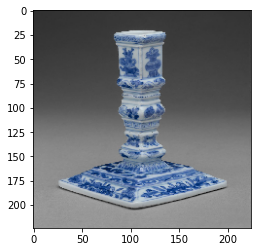

In [5]:
img, x = load_image("Prediction_Other_Source/The Met_1_清.tif")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

The shape of the image is [1, 224, 224, 3]. The reason it has the extra first dimension with 1 element is that the network can take batches of images to process them all simultaneously. So for example, 10 images can be propagated through the network if `x` has a shape of [10, 224, 224, 3].

Let's get class predictions from this model. We forward `x` through `model` and then use the built-in `decode_predictions` to look up the class names.

In [6]:
# Forward the image through the network
predictions = model.predict(x)

# Print out the prediction. 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))

predicted goblet with probability 0.930
predicted vase with probability 0.022
predicted table_lamp with probability 0.010
predicted pedestal with probability 0.009
predicted perfume with probability 0.006


### Feature extraction

What we have in the `model` variable is a highly effective image classifier trained on the ImageNet database. We expect that the classifier must form a very effective representation of the image in order to be able to classify it with such high accuracy. We can use this to our advantage by re-purposing this for another task.

What we do is we copy the model, but remove the last layer (the classification layer), so that the final layer of the new network, called `feat_extractor` is the second 4096-neuron fully-connected layer, "fc2 (Dense)".

The way we do this is by instantiating a new model called `feature_extractor` which takes a reference to the desired input and output layers in our VGG16 model. Thus, `feature_extractor`'s output is the layer just before the classification, the last 4096-neuron fully connected layer. It looks like a copy, but internally, all Keras is doing is making a pointer to each of these layers and not actually copying anything. Thus, the output "prediction" from `feat_extractor` will just be the layer `fc2` from `model`.

If we run the `summary()` function again, we see that the architecture of `feat_extractor` is identical to the original `model`, except the last layer has been removed. We also know that not just the architecture is the same, but the two have the same weights as well.

In [7]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Now let's see the feature extractor in action. We pass the same image from before into it, and look at the results. The `predict` function returns an array with one element per image (in our case, there is just one). Each element contains a 4096-element array, which is the activations of the last fully-connected layer `fc2` in VGG16. Let's plot the array as well.

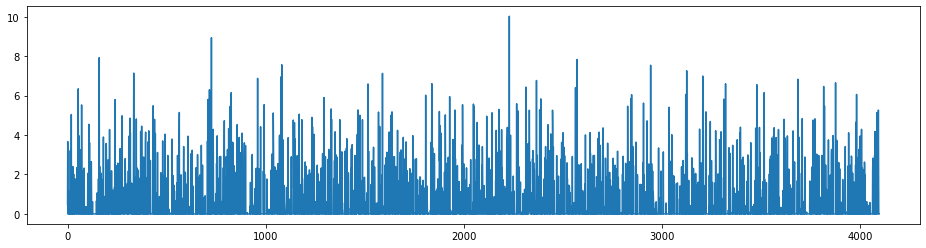

In [8]:
img, x = load_image("Prediction_Other_Source/The Met_1_清.tif")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

Our expectation is that the `fc2` activations form a very good representation of the image, such that similar images should produce similar activations. In other words, the `fc2` activations of two images which have similar content should be very close to each other. We can exploit this to do information retrieval. 

In the next cell, we will open a folder of images for analysis. First, the next cell will just recursively crawl the folder specified by `image_path` looking for images of the extensions inside of `image_extensions` and then limiting them to a random subset of maximum `max_num_images` images. Change these variables if you wish to change the target images.

In [9]:
images_path = 'Data'
image_extensions = ['.tif']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 2000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 1479 images to analyze


In the next cell, we will begin a loop which will open each image, extract its feature vector, and append it to a list called `features` which will contain our activations for each image. This process may take a long time depending on your graphics card, so you may need to leave it running for as much as a few hours. On a good graphics card, this process may only take a half hour or so. Every 1000 images, you will receive a notification print-out.

In [10]:
import time
# tic = time.clock()  # Removed from time library in the latest library.
tic = time.process_time()


features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.process_time()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.process_time()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

analyzing image 0 / 1479. Time: 0.0000 seconds.
analyzing image 500 / 1479. Time: 323.0625 seconds.
analyzing image 1000 / 1479. Time: 326.7031 seconds.
finished extracting features for 1479 images


Alone, these activations provide a good representation, but it is a good idea to do one more step before using these as our feature vectors, which is to do a [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) to reduce the dimensionality of our feature vectors down to 300. We apply PCA for two reasons: 1) the 4096-bit feature vector may have some redundancy in it, such that multiple elements in the vector are highly correlated or similar. This would skew similarity comparisons towards those over-represented features. 2) Operating over 4096 elements is inefficient both in terms of space/memory requirements and processor speed, and it would be better for us if we can reduce the length of these vectors but maintain the same effective representation. PCA allows us to do this by reducing the dimensionality down of the feature vectors from 4096 to much less, but maintain a representation which is still faithful to the original data, by preserving the relative inter-point distance.

Thus, PCA reduces the amount of redundancy in our features (from duplicate or highly-correlated features), speeds up computation over them, and reduces the amount of memory they take up.

The next cell will instantiate a `PCA` object, which we will then fit our data to, choosing to keep the top 300 principal components. This may take a few minutes.

In [11]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

PCA(n_components=300)

The `pca` object stores the actual transformation matrix which was fit in the previous cell. We can now use it to transform any original feature vector (of length 4096) into a reduced 300-dimensional feature vector in the principal component space found by the PCA. 

So we take our original feature vectors, and transform them to the new space.

In [12]:
pca_features = pca.transform(features)

In [13]:
print(pca_features)

[[-15.037226     1.644436    21.562614   ...   0.17770548   0.3862173
   -2.527587  ]
 [-24.499186   -12.915452    -4.3628435  ...  -0.39233625  -0.23574801
   -0.08391425]
 [ 12.813042    23.333302    -3.968575   ...   0.10551623   0.6247104
    0.21217978]
 ...
 [-23.871853   -12.414883     0.7928923  ...   0.1014114    0.90859413
   -0.9481532 ]
 [-25.79459    -15.086739     6.0201273  ...   0.59760284   0.7361055
   -0.55886686]
 [-23.057648   -18.93609      4.1942616  ...   1.9381123   -2.0832765
    2.5827775 ]]


### Reverse Image Search

We are now ready to do our reverse image queries! The matrix `pca_features` contains a compact representation of our images, one 300-element row for each image with high-level feature detections. We should expect that two similar images, which have similar content in them, should have similar arrays in `pca_features`.

Let's pick a random query image.

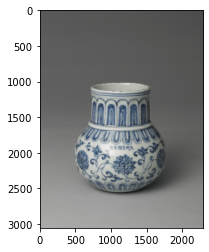

In [14]:
import random

# Choose a random query image.
query_image_idx = int(len(images) * random.random())

# Display the image.
img = image.load_img(images[query_image_idx])
plt.imshow(img)

The assumption we can now make is that two images which have similar content, should produce similar feature vectors. The next two cells will randomly select one image, and then compute a measurement of the dissimilarity (or distance) of that image's PCA feature vector to every other image's feature vector. The dissimilarity metric we use is [cosine distance](https://en.wikipedia.org/wiki/Cosine_similarity). 

In [15]:
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

The list `similar_idx` contains the image's similarity to every other one. We can sort that list and find the indexes of the most similar images. The next cell will sort them, and then find the most similar items, and return the indexes 5 most similar images. Notice we take from indexes 1:6 rather than 0:5 because the most similar image to the query image, will trivially be the query image itself, since it is included in the distance calculation. So we just skip it.

In [16]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]

The next cell opens the images specified by `idx_closest` and concatenates them into a single image (resizing each so it has a height of 100 pixels.

[953, 922, 951, 952, 42]


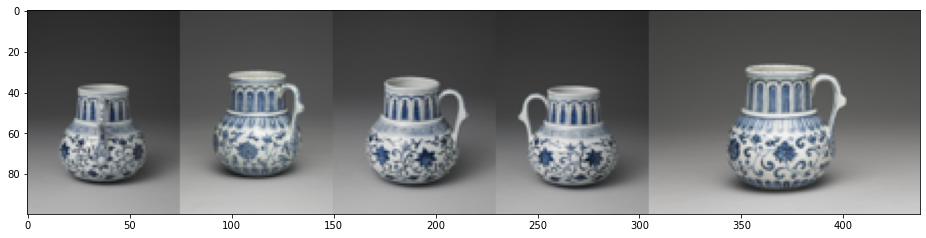

In [17]:
# load all the similarity results as thumbnails of height 100
thumbs = []
label = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)
    label.append(idx)
    
# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)

print(label)

### Image Search Function

For convenience, we'll automate this process by defining the function `get_closest_images`, which will compute the cosine distance between the PCA features of `query_image_idx`-th image in our dataset, and the PCA features of every image in the dataset (including itself, trivially 0). It then returns an array of indices to the `num_results` (default is 5) most similar images to it (not including itself). 

We also define a helper function `get_concatenated_images` which will simply take those resulting images and concatenate them into a single image for easy display.

In [18]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Example 1:

Text(0.5, 1.0, 'result images')

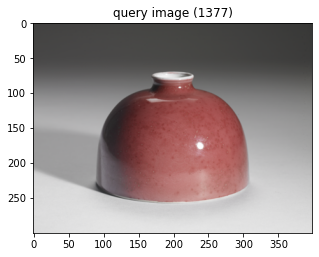

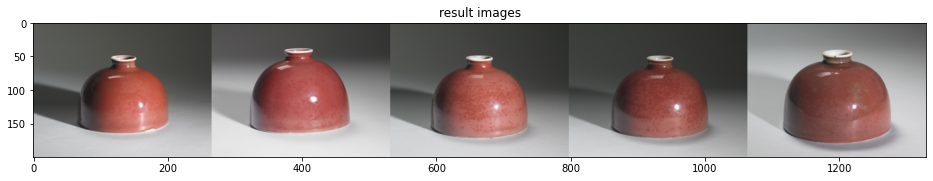

In [19]:
# Choose a random image.
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# Display the query image.
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# Display the resulting images.
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

Example two:

Text(0.5, 1.0, 'result images')

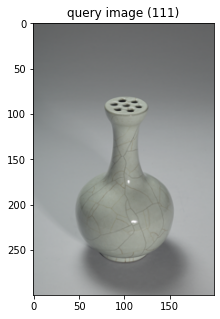

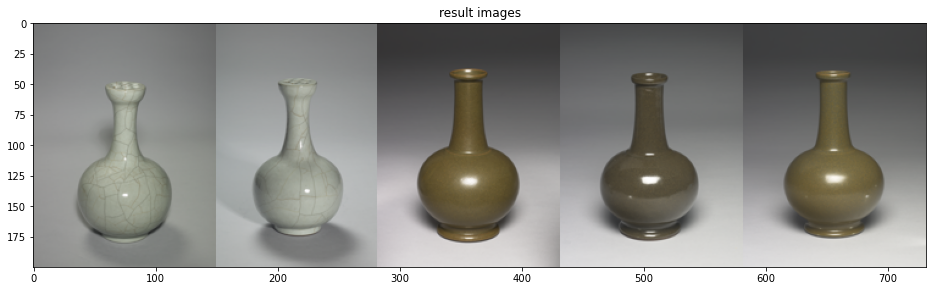

In [20]:
# Choose a random image.
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# Display the query image.
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# Display the resulting images.
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

## Importing new images

What if you load a new image which was not previously in the analysis?  For that, we can simply run it through the same process by extracting its feature vector, and projecting it into our PCA space using the saved pca object. So for example...

Text(0.5, 1.0, 'result images')

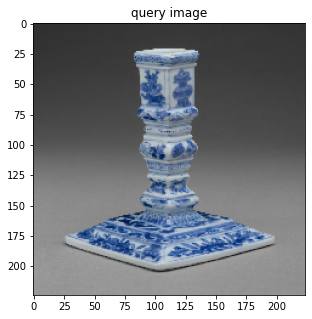

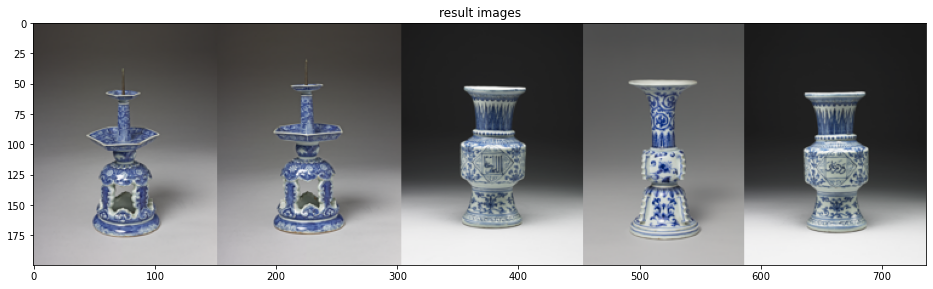

In [23]:
# load image and extract features.
new_image, x = load_image("Prediction_Other_Source/The Met_1_清.tif")
new_features = feat_extractor.predict(x)

# Project it into pca space.
new_pca_features = pca.transform(new_features)[0]

# Calculate its distance to all the other images pca feature vectors.
distances = [ distance.cosine(new_pca_features, feat) for feat in pca_features ]
idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[0:5]  # grab first 5
results_image = get_concatenated_images(idx_closest, 200)

# Display the results.
plt.figure(figsize = (5,5))
plt.imshow(new_image)
plt.title("query image")

# Display the resulting images.
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

Thus we can see the usefulness of feature vectors for tasks other than classification. Besides for similarity retrieval, these feature vectors can be broadly useful for other things. If we are satisfied with the quality of our image vectors, now would be a good time to save them to disk for later usage. You will need these vectors to run the [next notebook on making an image t-SNE](image-tsne.ipynb).

We need to save both the image features matrix (the PCA-reduced features, not the originals), as well as the array containing the paths to each image, to make sure we can line up the images to their corresponding vectors. It is also best to save `pca` itself so we can project new images into the space if we wish. We can save everything to disk using `pickle`.

In [22]:
# import pickle
# pickle.dump([images, pca_features, pca], open('/content/features_5cats.p', 'wb'))